#DESAFÍO Nro. 2 NLP: bot basado en reglas con DNN + Spacy.

Las modificaciones realizadas en relación con el ejercicio original fueron:

* Se agregó una solución con TF-IDF, se compara con BOW y se obtienen conclusiones.
* Se agregó el filtro de stop words.
* Se cambió al idioma inglés.
* Se optimizó la función de preprocesamiento para que ya contenga el tokenizador más el lematizador, además del filtro de signos de puntuación, números y otros caracteres especiales.
* Se modificó el corpus por una temática de IA.
* Se incorporó Gradio a modo de ejemplo (para utilizarlo es necesario correr la notebook).
* Se graficó la función de pérdida.

By Anahi Bazet

## 1 - Librerias

In [ ]:
# Se utilizará gradio para ensayar el bot.
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos.
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [ ]:
import spacy
import string
import re # Para expresiones regulares.
import numpy as np
import random 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.feature_extraction.text import TfidfVectorizer

## 2 - Herramientas de preprocesamiento de datos: función preprocess_clean_text
Entre las tareas de procesamiento de texto en inglés se implementa:
- Quitar números.
- Quitar símbolos de puntuación.
- Quitar más de un espacio, saltos de línea o tabulaciones.
- Quitar stop words.
- Tokenizar y lematizar.

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def preprocess_clean_text(text):

    # Filter others special symbols and numbers
    # Substituir números por un espacio vacío.
    text = re.sub(r'[0-9]',' ', text)
    # Substituir uno o más caracteres de espacio, saltos de línea o tabulaciones 
    # por un espacio vacío.
    text = re.sub(r'(\s+)',' ', text)
    #print("Remove others special symbols and numbers:")
    #print(text)
    #print ("\nTipo", type(text))
    
    doc = nlp(text)
    # Tokenization & lemmatization
    lemma_list = []
    #print("\nTokenize+Lemmatize:")
    for token in doc:
        lemma_list.append(token.lemma_)
        #print([token, token.lemma_])
    #print ("\nTipo", type(lemma_list))
    
    # Stop words
    filtered_sentence =[]
    for word in lemma_list:
        # word es un string, pero para recuperar la información de los objetos de SpaCy
        # necesitamos convertir el string a un lexema. El lexema es un objeto de SpaCy
        # que para cada término contiene la información del preprocesamiento
        # (se podría también directamente filtrar stopwords en el paso de lematización).
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    #print ("\nRemove stopword:")
    #print(filtered_sentence)
    #print ("\nTipo", type(filtered_sentence))

    # Filter punctuation
    filtered_sentence = [w for w in filtered_sentence if w not in string.punctuation]
    #print("\nRemove punctuation:")
    #print(filtered_sentence)

    return filtered_sentence

Se prueba el preprocesamiento de datos.

In [ ]:
text = "I'm botIA. Can I help you?\n I had 45 minutes."
# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens=preprocess_clean_text(text)
#print ("\nTipo de tokens", type(tokens))
print (tokens)

['botia', 'help', 'minute']


## 3 - Diccionario de entrada

El dataset incluido en este TP está basado en el siguiente dataset:
https://www.kaggle.com/datasets/mukeshmaji359/chat-bot-json-file-great-learning
y en este otro diccionario de entrada https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758

In [ ]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas (responses) por categoría (tag).
# Los "patterns" van a formar el corpus para entrenar la red que clasifica en tags.
# Los "responses" son las respuestas predeterminadas posibles para cada tag.

dataset = {"intents": [
        {"tag": "Intro",
         "patterns": ["hi", 
                      "how are you", 
                      "is anyone there", 
                      "hello", 
                      "whats up",
                      "hey",
                      "yo",
                      "listen", 
                      "please help me",
                      "i am learner from",
                      "i belong to",
                      "aiml batch",
                      "aifl batch",
                      "i am from",
                      "my pm is",
                      "blended",
                      "online",
                      "i am from",
                      "hey ya",
                      "talking to you for first time"],
         "responses": ["Hello! I'm your personal assistant botIA. How can I help you ?",
                       "Howdy Partner! How can I help you ?",
                       "Dear friend! How can I help you?"], 
         "context_set": ""
        },
        {"tag": "Exit",
         "patterns": ["thank you", 
                      "thanks", 
                      "cya",
                      "see you",
                      "later", 
                      "see you later", 
                      "goodbye", 
                      "i am leaving", 
                      "have a Good day",
                      "you helped me",
                      "thanks a lot",
                      "thanks a ton",
                      "you are the best",
                      "great help",
                      "too good",
                      "you are a good learning buddy"],
         "responses": ["I hope I was able to assist you, Good Bye", 
                       "It was nice speaking to you", 
                       "See you later"],
         "context_set": ""
        },
        {"tag": "GitHubCEIA",
         "patterns": ["GitHub",
                      "CEIA",
                      "explain me how GitHub works",
                      "I am not able to understand GitHub",
                      "no access to CEIA GitHub",
                      "unable to see link about CEIA in GitHub",
                      "lot of problems with GitHub",
                      "how to use GitHub",
                      "teach me GitHub"],
         "responses": ["GitHub is a code hosting platform for version control and collaboration. To know more visit https://docs.github.com/en. Our GitHub is https://github.com/FIUBA-Posgrado-Inteligencia-Artificial."],
         "context_set": ""
        },
        {"tag": "SVM",
         "patterns": ["i am not able to understand svm",
                      "support vector machine"],
         "responses": ["SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes."],
         "context_set": ""
        },

        {"tag": "ML",
         "patterns": ["explain me how machine learning works",
                      "machine learning",
                      "ML"],
         "responses": ["Machine learning is a method of data analysis that automates analytical model building. It is a branch of artificial intelligence based on the idea that systems can learn from data, identify patterns and make decisions with minimal human intervention."],
         "context_set": ""
        },
        {"tag": "NB",
         "patterns": ["i am not able to understand naive bayes",
                      "naive bayes",
                      "nb"],
         "responses": ["Naive Bayes is a simple technique for constructing classifiers: models that assign class labels to problem instances, represented as vectors of feature values, where the class labels are drawn from some finite set. There is not a single algorithm for training such classifiers, but a family of algorithms based on a common principle: all naive Bayes classifiers assume that the value of a particular feature is independent of the value of any other feature, given the class variable."],
         "context_set": ""
        },
        {"tag": "LR",
         "patterns": ["i am not able to understand logistic regression",
                      "logistic regression",
                      "regression"],
         "responses": ["Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression)."],
         "context_set": ""
        },
        {"tag": "EN",
         "patterns": ["i am not able to understand ensemble techb=niques",
                      "ensemble techniques",
                      "bagging",
                      "boosting",
                      "ada boosting",
                      "ada",
                      "gradient boosting",
                      "hyper parameters"],
         "responses": ["Ensemble learning helps improve machine learning results by combining several models. This approach allows the production of better predictive performance compared to a single model. That is why ensemble methods placed first in many prestigious machine learning competitions, such as the Netflix Competition, KDD 2009, and Kaggle."],
         "context_set": ""
        },
        {"tag": "DL",
         "patterns": ["what is deep learning", 
                      "unable to understand deep learning",
                      "explain me how deep learning works",
                      "i am not able to understand deep learning"],
         "responses": ["Deep learning is a subset of machine learning in artificial intelligence that has networks capable of learning unsupervised from data that is unstructured or unlabeled. Also known as deep neural learning or deep neural network."],
         "context_set": ""
        },
        {"tag": "NN",
         "patterns": ["not able to understand neural nets",
                      "very diffult to understand neural nets",
                      "unable to understand neural nets",
                      "ann", 
                      "artificial intelligence", 
                      "artificial neural networks"],
         "responses": ["A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature."],
         "context_set": ""
        },
        {"tag": "AF",
         "patterns": ["activation function",
                      "softmax",
                      "sigmoid",
                      "relu"],
         "responses": ["An activation function in a neural network defines how the weighted sum of the input is transformed into an output from a node or nodes in a layer of the network."],
         "context_set": ""
        },
        {"tag": "OP",
         "patterns": ["optimizer",
                      "adam",
                      "sgd"],
         "responses": ["Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Optimizers are used to solve optimization problems by minimizing the function."],
         "context_set": ""
        },

        {"tag": "Others",
         "patterns": ["weights",
                      "hidden layers",
                      "forward propagation",
                      "backward propagation",
                      "epochs",
                      "epoch",
                      "what is an epoch"],
         "responses": ["I don't have enough information about this topic. Please contact your teacher."],
         "context_set": ""
        },
        {"tag": "NLP",
         "patterns": ["NLP",
                      "spacy",
                      "nltk",
                      "bag of words", 
                      "embeddings", 
                      "TD-IDF",
                      "lemmatization",
                      "tokenization"],
         "responses": ["The best topics in CEIA! Please visit https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural"],
         "context_set": ""
        },
         {"tag": "Bot",
         "patterns": ["what is your name",
                      "who are you",
                      "name please",
                      "when are your hours of operations", 
                      "what are your working hours", 
                      "hours of operation",
                      "working hours",
                      "hours"],
         "responses": ["I am botIA your virtual learning assistant"],
         "context_set": ""
        },
        {"tag": "Ticket",
         "patterns": ["my problem is not solved", 
                      "you did not help me", 
                      "not a good solution",
                      "bad solution",
                      "not good solution",
                      "no help",
                      "wasted my time",
                      "useless bot",
                      "create a ticket"],
         "responses": ["Transferring the request to your teacher"],
         "context_set": ""
        }
   ]
}

## 4 - Armado del dataset aplicando el preprocesamiento de datos

In [ ]:
# Datos que necesitaremos, las palabras o vocabulario.
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X.
# El tag de cada intención se almacena como doc_Y (la clase a predecir).
# En `words` vamos a guardar el vocabulario.
# En `class` las posibles clases o tags.

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        #preprocess_clean_text tokeniza y lematiza también.
        words.extend(preprocess_clean_text(pattern))
        #print ("Tipo words:", type(words))
        #print (words)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases.
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Eliminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético.
words = sorted(set(words))
classes = sorted(set(classes))

In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['CEIA', 'GitHub', 'IDF', 'ML', 'NLP', 'TD', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'ann', 'artificial', 'backward', 'bad', 'bag', 'batch', 'baye', 'belong', 'blend', 'boost', 'bot', 'buddy', 'ceia', 'create', 'cya', 'day', 'deep', 'diffult', 'embedding', 'ensemble', 'epoch', 'explain', 'forward', 'function', 'github', 'good', 'goodbye', 'gradient', 'great', 'hello', 'help', 'hey', 'hi', 'hide', 'hour', 'hyper', 'intelligence', 'later', 'layer', 'learner', 'learning', 'leave', 'lemmatization', 'link', 'listen', 'logistic', 'lot', 'machine', 'naive', 'nb', 'net', 'network', 'neural', 'nique', 'nltk', 'online', 'operation', 'optimizer', 'parameter', 'pm', 'problem', 'propagation', 'regression', 'relu', 's', 'sgd', 'sigmoid', 'softmax', 'solution', 'solve', 'spacy', 'support', 'svm', 'talk', 'teach', 'techb', 'technique', 'thank', 'ticket', 'time', 'tokenization', 'ton', 'unable', 'understand', 'use', 'useless', 'vector', 'waste', 'weight', 'word', 'work', '

In [ ]:
# Tamaño del vocabulario.
print("Vocabulario:", len(words))

Vocabulario: 107


In [ ]:
# Cantidad de tags.
print("Tags:", len(classes))

Tags: 16


In [ ]:
# Tamaño del dataset.
print ("doc_x",len(doc_X))
#print (type(doc_X))
print ("doc_y",len(doc_y))

doc_x 113
doc_y 113


### Bag of words

In [ ]:
# Transformar doc_X en bag of words por oneHotEncoding.
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding.

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar.
    text = []
    text.extend(preprocess_clean_text(doc))

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0).
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente.
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    #print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos.
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida.
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

#RESUMEN:
# x puede tener más de un 1. Se toma el vocabulario y se coloca un 1 en donde
# en el documento de doc_X se menciona esa palabra.
# y tiene un 1 según la posición en la lista de classes relacionado al tag del doc_y.

### TF-IDF

In [ ]:
# Transformar doc_X en TF-IDF.
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding.

training_TFIDF = []
out_empty_TFIDF = [0] * len(classes)

# Crear un vectorizador TF-IDF.
word_vectorizer = TfidfVectorizer(tokenizer=preprocess_clean_text,lowercase=False,vocabulary=words)

# Crear los vectores TF-IDF a partir de cada documento.
TFIDF = word_vectorizer.fit_transform(doc_X)  

arr_X=TFIDF.toarray()
# print ("Vector",arr_X[48,:])
# print (arr_X.shape)

for idx_TFIDF, doc_TFIDF in enumerate(doc_X):
    
    # Crear el array de salida (class output) correspondiente.
    output_row_TFIDF = list(out_empty_TFIDF)
    output_row_TFIDF[classes.index(doc_y[idx_TFIDF])] = 1

    #print("X:", arr_X[idx,:], "y:", output_row_TFIDF)
    training_TFIDF.append([arr_X[idx_TFIDF,:], output_row_TFIDF])

# Mezclar los datos.
random.shuffle(training_TFIDF)
training_TFIDF = np.array(training_TFIDF, dtype=object)
# Dividir en datos de entrada y salida.
train_X_TFIDF = np.array(list(training_TFIDF[:, 0]))
train_y_TFIDF = np.array(list(training_TFIDF[:, 1]))

## 5 - Entrenamiento del modelo

### Bag of words

In [ ]:
# Shape de entrada y salida.
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)
# Esto es así porque el vocabulario es 107 y los tags son 16.

input: (107,) output: 16


In [ ]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - Softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13824     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
Total params: 23,120
Trainable params: 23,120
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epoch_cant=200
hist = model.fit(x=train_X, y=train_y, epochs=epoch_cant)

Epoch 1/200
4/4 [==============================] - 1s 7ms/step - loss: 2.7867 - accuracy: 0.0531
Epoch 2/200
4/4 [==============================] - 0s 7ms/step - loss: 2.7488 - accuracy: 0.0796
Epoch 3/200
4/4 [==============================] - 0s 5ms/step - loss: 2.7447 - accuracy: 0.1327
Epoch 4/200
4/4 [==============================] - 0s 5ms/step - loss: 2.7137 - accuracy: 0.1504
Epoch 5/200
4/4 [==============================] - 0s 19ms/step - loss: 2.7210 - accuracy: 0.1504
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 2.7051 - accuracy: 0.1416
Epoch 7/200
4/4 [==============================] - 0s 13ms/step - loss: 2.6903 - accuracy: 0.1858
Epoch 8/200
4/4 [==============================] - 0s 6ms/step - loss: 2.6590 - accuracy: 0.2301
Epoch 9/200
4/4 [==============================] - 0s 15ms/step - loss: 2.6640 - accuracy: 0.1681
Epoch 10/200
4/4 [==============================] - 0s 11ms/step - loss: 2.6201 - accuracy: 0.2566
Epoch 11/200
4/4 [=======

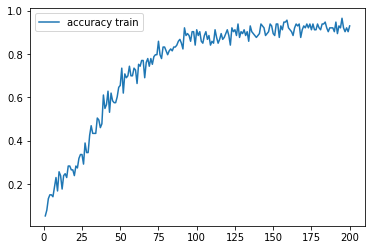

In [ ]:
# Entrenamiento métrica.
epoch_count = range(1, epoch_cant+1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='accuracy train')
plt.show()

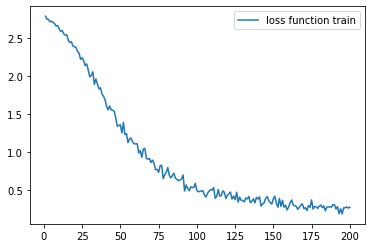

In [ ]:
# Entrenamiento función de pérdida.
epoch_count = range(1, epoch_cant+1)
sns.lineplot(x=epoch_count, y=hist.history['loss'], label='loss function train')
plt.show()

### TF-IDF

In [ ]:
# Shape de entrada y salida.
input_shape_TFIDF = (train_X_TFIDF.shape[1],)
output_shape_TFIDF= train_y_TFIDF.shape[1]
print("input:", input_shape_TFIDF, "output:", output_shape_TFIDF)
# Esto es así porque el vocabulario es 107 y los tags son 16.

input: (107,) output: 16


In [ ]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - Softmax y optimizador Adam
model_TFIDF = Sequential()
model_TFIDF.add(Dense(128, input_shape=input_shape_TFIDF, activation="relu"))
model_TFIDF.add(Dropout(0.5))
model_TFIDF.add(Dense(64, activation="relu"))
model_TFIDF.add(Dropout(0.5))
model_TFIDF.add(Dense(output_shape_TFIDF, activation = "softmax"))

model_TFIDF.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])

print(model_TFIDF.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               13824     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
Total params: 23,120
Trainable params: 23,120
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epoch_cant=200
hist_TFIDF = model_TFIDF.fit(x=train_X_TFIDF, y=train_y_TFIDF, epochs=epoch_cant)

Epoch 1/200
4/4 [==============================] - 1s 6ms/step - loss: 2.7633 - accuracy: 0.0973
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 2.7393 - accuracy: 0.1327
Epoch 3/200
4/4 [==============================] - 0s 5ms/step - loss: 2.7390 - accuracy: 0.1593
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 2.7045 - accuracy: 0.1593
Epoch 5/200
4/4 [==============================] - 0s 5ms/step - loss: 2.6883 - accuracy: 0.1858
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 2.6545 - accuracy: 0.1858
Epoch 7/200
4/4 [==============================] - 0s 6ms/step - loss: 2.6574 - accuracy: 0.1947
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 2.5997 - accuracy: 0.2389
Epoch 9/200
4/4 [==============================] - 0s 8ms/step - loss: 2.6041 - accuracy: 0.2478
Epoch 10/200
4/4 [==============================] - 0s 8ms/step - loss: 2.5854 - accuracy: 0.2301
Epoch 11/200
4/4 [==========

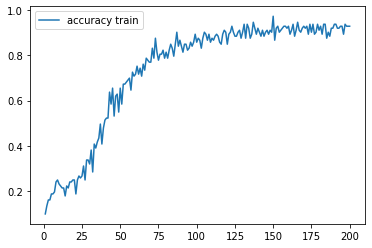

In [ ]:
# Entrenamiento métrica.
epoch_count = range(1, epoch_cant+1)
sns.lineplot(x=epoch_count, y=hist_TFIDF.history['accuracy'], label='accuracy train')
plt.show()

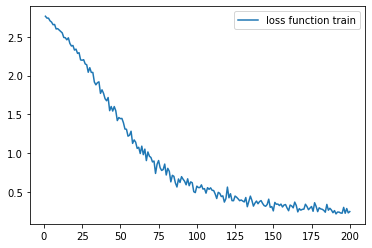

In [ ]:
# Entrenamiento función de pérdida.
epoch_count = range(1, epoch_cant+1)
sns.lineplot(x=epoch_count, y=hist_TFIDF.history['loss'], label='loss function train')
plt.show()

## 6 - Testing y validación

Se utilizarán las siguientes frases, tanto para BOW, como para TF-IDF:

1) Hi!

2) What is NLP?

3) But, I don't know anything about neural networks.

4) Thanks.

### Bag of words

In [ ]:
# Transformar el texto de entrada tokenizado a una representación OHE.
def bag_of_words(text, vocab): 
    tokens = preprocess_clean_text(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print("bow del mensaje",bow)
    return np.array(bow)

# Usar modelo con la entrada en OHE y los labels posibles (tags).
# text: mensaje del usuario.
# vocab: vocabulario.
# labels: el vector de tags (clases).
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    #print ("Shape del bow",bow.shape)
    words_recognized = sum(bow)
    # Si está en cero, quiere decir que el el mensaje dado por el usuario
    # no contiene ninguna palabra del vocabulario.
    
    return_list = []
    if words_recognized > 0: # Sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # Es un array de softmax.
        #print ("Softmax array:",result)
        thresh = 0.2
        # Filtrar aquellas entradas menores al umbral `thresh`.
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        #print ("Umbral array:",y_pred)
        # Ordenar keys de acuerdo al valor softmax (puede haber más de uno que 
        # supere el umbral).
        y_pred.sort(key=lambda x: x[1], reverse=True)
        #print ("Order array:",y_pred)
    
        # return_list es una lista de los labels de mayor a menor.
        for r in y_pred:
            return_list.append(labels[r[0]])
        #print ("Return list",return_list)

    # Si no reconoció palabras del vocabulario se devuelve una lista vacía.
    return return_list

# Obtener una respuesta predeterminada. 
# intents_list son los tags que reconoción la red neuronal.
# intents_json es todo el dataset: tag + preguntas + respuestas.
def get_response(intents_list, intents_json):
    #Esta es la intrucción en donde se queda con un solo tag.
    tag = intents_list[0] # Tomar el tag con el mejor valor softmax (mayor).
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag: # Buscar el tag correspondiente y dar una respuesta predeterminada aleatoria 
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

####Sin Gradio

In [ ]:
print ("Welcome to the chatbot. If you want to finish, please write 'quit'.")
while True:
    # Pedir input al usuario.
    message = input("")
    if message=='quit':
      break
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else: # Si no hubo ningún resultado que supere el umbral.
        print("I'm sorry, I don't understand this question.")   

Welcome to the chatbot. If you want to finish, please write 'quit'.
Hi!
BOT: Dear friend! How can I help you?
What is NLP?
BOT: The best topics in CEIA! Please visit https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural
But, I don't know anything about neural networks.
BOT: A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature.
Thanks.
BOT: I hope I was able to assist you, Good Bye
quit


#### Con Gradio

In [32]:
def bot_response(human):
    intents = pred_class(human, words, classes)
    if len(intents) > 0:
        return get_response(intents, dataset)
    else: # Si no hubo ningún resultado que supere el umbral.
        return "I'm sorry, I don't understand this question."   

iface = gr.Interface(
    fn=bot_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://17909.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f7308bec390>,
 'http://127.0.0.1:7862/',
 'https://17909.gradio.app')

### TF-IDF

In [ ]:
# Transformar el texto de entrada tokenizado a una representación TF-IDF.
def TF_IDF(text, vocab): 
    # Crear un vectorizador TF-IDF.
    word_vectorizer = TfidfVectorizer(tokenizer=preprocess_clean_text,lowercase=False,vocabulary=vocab)

    # Crear los vectores TF-IDF a partir del mensaje del usuario.
    #print (type(text))
    text_list=[]
    text_list.append(text)
    #print (type(text_list))
    TFIDF = word_vectorizer.fit_transform(text_list)  

    arr_X=TFIDF.toarray()
    arr_X=np.squeeze(arr_X,axis=0)
    #print("TF-IDF del mensaje",arr_X)
    return arr_X

# Usar modelo con la entrada en TF-IDF y los labels posibles (tags).
# text: mensaje del usuario.
# vocab: vocabulario.
# labels: el vector de tags (clases).
def pred_class(text, vocab, labels): 
    tfidf = TF_IDF(text, vocab)
    #print ("Shape del tfidf",tfidf.shape)
    words_recognized = sum(tfidf)
    # Si está en cero, quiere decir que el el mensaje dado por el usuario
    # no contiene ninguna palabra del vocabulario.
    
    return_list = []
    if words_recognized > 0: # Sólo si reconoció alguna palabra del vocabulario
        result = model_TFIDF.predict(np.array([tfidf]))[0] # Es un array de softmax.
        #print ("Softmax array:",result)
        thresh = 0.2
        # Filtrar aquellas entradas menores al umbral `thresh`.
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        #print ("Umbral array:",y_pred)
        # Ordenar keys de acuerdo al valor softmax (puede haber más de uno que 
        # supere el umbral).
        y_pred.sort(key=lambda x: x[1], reverse=True)
        #print ("Order array:",y_pred)
    
        # return_list es una lista de los labels de mayor a menor.
        for r in y_pred:
            return_list.append(labels[r[0]])
        #print ("Return list",return_list)

    # Si no reconoció palabras del vocabulario se devuelve una lista vacía.
    return return_list

# Obtener una respuesta predeterminada. 
# intents_list son los tags que reconoción la red neuronal.
# intents_json es todo el dataset: tag + preguntas + respuestas.
def get_response(intents_list, intents_json):
    #Esta es la intrucción en donde se queda con un solo tag.
    tag = intents_list[0] # Tomar el tag con el mejor valor softmax (mayor).
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag: # Buscar el tag correspondiente y dar una respuesta predeterminada aleatoria 
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

####Sin Gradio

In [ ]:
print ("Welcome to the chatbot. If you want to finish, please write 'quit'.")
while True:
    # Pedir input al usuario.
    message = input("")
    if message=='quit':
      break
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else: # Si no hubo ningún resultado que supere el umbral.
        print("I'm sorry, I don't understand this question.")   

Welcome to the chatbot. If you want to finish, please write 'quit'.
Hi!
BOT: Hello! I'm your personal assistant botIA. How can I help you ?
What is NLP?
BOT: The best topics in CEIA! Please visit https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural
But, I don't know anything about neural networks.
BOT: A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature.
Thanks.
BOT: I hope I was able to assist you, Good Bye
quit


## 7 - Conclusiones

### Gráfico comparativo de entrenamiento entre BOW y TF-IDF

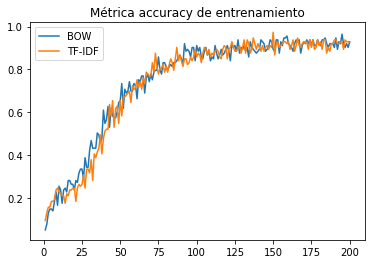

In [ ]:
# Entrenamiento métrica.
epoch_count = range(1, epoch_cant+1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='BOW')
sns.lineplot(x=epoch_count, y=hist_TFIDF.history['accuracy'], label='TF-IDF')
plt.title("Métrica accuracy de entrenamiento")
plt.show()

Los resultados de entrenamiento son similares, ya que alcanzan el mismo nivel de accuracy en la misma cantidad de epochs con la misma arquitectura.

### Acerca del testing y validación

Tanto BOW, como TF-IDF, interactúan correctamente con el humano según las frases ingresadas. Lógicamente, la respuesta puede variar en los casos en donde hay más de una, porque es random.